In [1]:
import TimeSliceImport
import numpy as np
import keras
import random
from keras.models import Sequential

from keras.layers import (Dense, Dropout, Activation, Conv1D,Conv2D, Flatten)
from keras.layers import (MaxPooling1D,BatchNormalization,MaxPooling2D, GlobalAveragePooling1D,LeakyReLU)
from keras.optimizers import SGD

from sklearn import (metrics,preprocessing,model_selection)
import RamanPlotTools as pt
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
from mpl_toolkits import mplot3d
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
from keras.backend import tensorflow_backend as backend
from keras import backend as K
import gc
print(backend.device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15688310334801313336
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7520164250
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11710518187493634303
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
path="/home/waseda/Desktop/shared/SKYP_KYP_SYP"
numClasses=4
types=["PS", "yeast","spore","kleb"]
spectra=TimeSliceImport.importData(path,types)
classes=list(map(lambda x:TimeSliceImport.RamanSample.mappings[x],types))
sortedTypesTuples=sorted(zip(types,classes),key=lambda x:x[1])
sortedTypes=[x[0] for x in sortedTypesTuples]

startPNT=201


def makeRandomData(filter="NONE",start=startPNT,end=1600,points=1000,removeBG=False):
    trainingSamples, validationSamples = TimeSliceImport.splitData(spectra, 0.25)
    trainingSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points, filter=filter,removeBackground=removeBG), trainingSamples))
    validationSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points,filter=filter,removeBackground=removeBG), validationSamples))
    trainingData,trainingClasses,validationData,validationClasses = TimeSliceImport.makeSVMInputData(trainingSpectraList,
                                                                                                     validationSpectraList)

    oneHotTrainingClasses=keras.utils.to_categorical(trainingClasses,num_classes=numClasses)
    oneHotValidationClasses=keras.utils.to_categorical(validationClasses,num_classes=numClasses)
    return trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses

trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=makeRandomData()


def makeRandomDataBySpectra(filter="NONE",start=startPNT,end=1600,points=1000,removeBG=False,normalize=True):
    spectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points, filter=filter,removeBackground=removeBG), spectra))
    x = np.transpose(np.concatenate([t[0] for t in spectraList], axis=1))
    y = np.concatenate([t[1] for t in spectraList]).ravel()
    oneHotClasses = keras.utils.to_categorical(y,num_classes=numClasses)
    
    if normalize is True:
        preprocessing.minmax_scale(x, axis=1, copy=False)
        
    return model_selection.train_test_split(x,oneHotClasses,test_size=0.25,stratify=y)
    


def scalarClassesFromOneHotArray(oneHotArray):
    return np.argmax(oneHotArray,axis=1)

def plotResult(truth,result, score, normalize=False):
    pt.plotResult(scalarClassesFromOneHotArray(result),scalarClassesFromOneHotArray(truth),sortedTypes)
    mtrx = metrics.confusion_matrix(scalarClassesFromOneHotArray(truth),scalarClassesFromOneHotArray(result))
    pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % score, normalize=normalize)

def plotLearning(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training Loss', 'Cross-Validation Loss'])
    plt.show()

In [4]:
xTrain,xTest,yTrain,yTest=makeRandomDataBySpectra(start=startPNT,end=2500,points=1000)

inverseMappings={}
for key in TimeSliceImport.RamanSample.mappings:
    inverseMappings[TimeSliceImport.RamanSample.mappings[key]]=key

print("{} Training Spectra".format(xTrain.shape[0]))
_,cl=np.unique(yTrain,return_counts=True,axis=0)

for idx,count in enumerate(cl):
    label=inverseMappings[idx]
    print("\tClass {}: {}".format(label,count))

print("{} Validation Spectra".format(xTest.shape[0]))

_,cl=np.unique(yTest,return_counts=True,axis=0)

for idx,count in enumerate(cl):
    label=inverseMappings[idx]
    print("\tClass {}: {}".format(label,count))


1867 Training Spectra
	Class spore: 450
	Class kleb: 450
	Class PS: 517
	Class yeast: 450
623 Validation Spectra
	Class spore: 150
	Class kleb: 150
	Class PS: 173
	Class yeast: 150


In [5]:
def makeModel(lossFunction="categorical_crossentropy", optimizer="Adam", points=100):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=points))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(numClasses, activation='softmax'))
    if optimizer == "SGD":
        o = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    elif optimizer == "Adam":
        o = Adam()
    model.compile(loss=lossFunction, optimizer=o, metrics=['accuracy'])
    return model

def makeModelCNN(batchNormalize=False,points=100):
    model = Sequential()
    model.add(Conv1D(16,21, input_shape=(points, 1)))
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())
    model.add(MaxPooling1D(2,2))
    
    model.add(Conv1D(32,11))
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())
    model.add(MaxPooling1D(2,2))
    
    model.add(Conv1D(64,5))
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())
    model.add(MaxPooling1D(2,2))
    
    model.add(Flatten())
    model.add(Dense(2048))
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(Activation("tanh"))
    # model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))
   
    model.add(Dense(numClasses))
    if batchNormalize is True:
        model.add(BatchNormalization())
    model.add(Activation("softmax"))
        
    model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [6]:
def runModel(numRepetitions=1):
    
    scores=[]
   
    labels=[]
    rangeEnds = np.linspace(2500,800,10)
    
    for rangeEnd in rangeEnds:
        
        for removeBG in [False]:
        
            runScores=[]
            results=[]
            truths=[]
            label="{0:.1f}".format(rangeEnd)
            labels.append(label)
            dist=rangeEnd-startPNT
            print(label)
            
            for i in range(numRepetitions):

                xTrain,xTest,yTrain,yTest=makeRandomDataBySpectra(end=rangeEnd,removeBG=removeBG,points=dist)
                
                model=makeModel(points=xTrain.shape[1])
                
                if i==0:
                    print(model.summary())
                
                history = model.fit(xTrain, yTrain, epochs=400, validation_split=0.1, verbose=0)
                score = model.evaluate(xTest, yTest)
                prd = model.predict(xTest)
                skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(yTest),scalarClassesFromOneHotArray(prd))
                print("Score: {}, SKScore: {}".format(score[1], skScore))
                print(skScore)
                results.extend(scalarClassesFromOneHotArray(prd))
                runScores.append(skScore)
                truths.extend(scalarClassesFromOneHotArray(yTest))
                plt.plot(history.history['acc'], color='blue')
                plt.plot(history.history['val_acc'], color='orange')
                
                K.clear_session()
                del history
                del model
                gc.collect()

            avgScore=sum(runScores)/float(len(runScores))
            print("Score: {}".format(avgScore))
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
            plt.show()
            scores.append(runScores)
            pt.plotResult(results,truths,sortedTypes)
            mtrx = metrics.confusion_matrix(truths,results)
            pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % avgScore, normalize=True)

    npScores=np.array(scores)
    return labels,npScores

2500.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               294400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 302,916
Trainable params: 302,916
Non-trainable params: 0
_________________________________________________________________
None
623/623 [==============================] - 0s 22us/step
Score: 0.5666131627884952, SKScore: 0.5666131621187801
0.56661316211

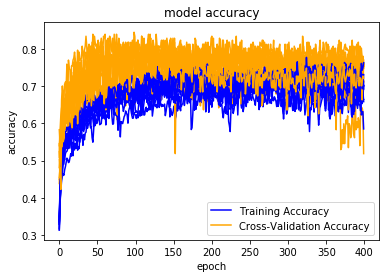

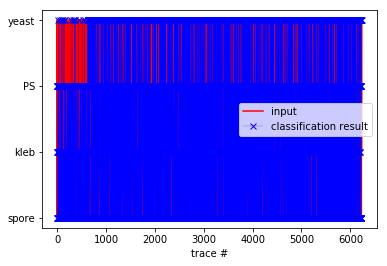

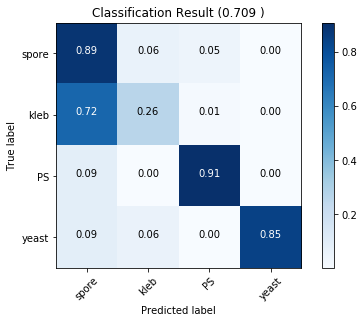

2311.1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               270208    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 278,724
Trainable params: 278,724
Non-trainable params: 0
_________________________________________________________________
None
623/623 [==============================] - 0s 19us/step
Score: 0.7431781706228302, SKScore: 0.7431781701444623
0.74317817014

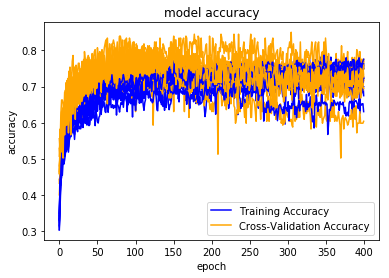

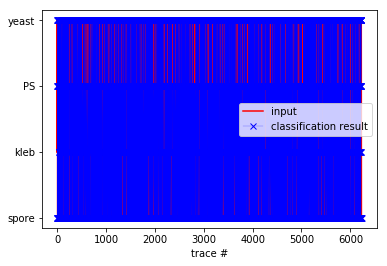

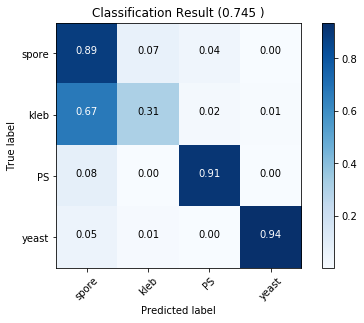

2122.2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               246016    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 254,532
Trainable params: 254,532
Non-trainable params: 0
_________________________________________________________________
None
623/623 [==============================] - 0s 19us/step
Score: 0.7881219903691814, SKScore: 0.7881219903691814
0.78812199036

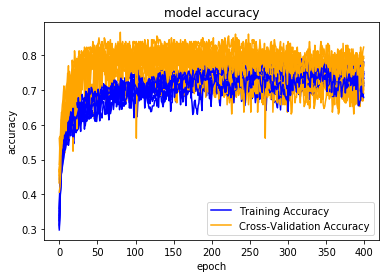

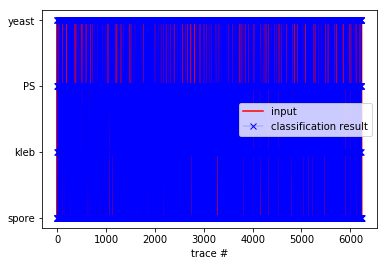

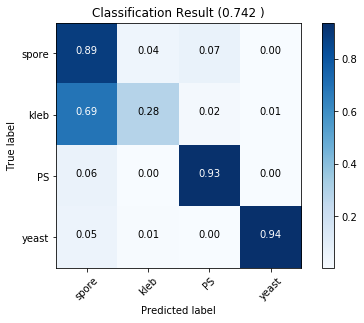

1933.3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               221824    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 230,340
Trainable params: 230,340
Non-trainable params: 0
_________________________________________________________________
None
623/623 [==============================] - 0s 19us/step
Score: 0.7303370792257269, SKScore: 0.7303370786516854
0.73033707865

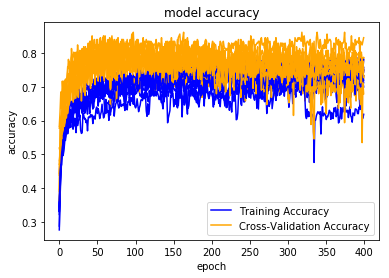

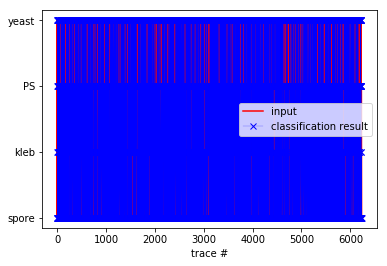

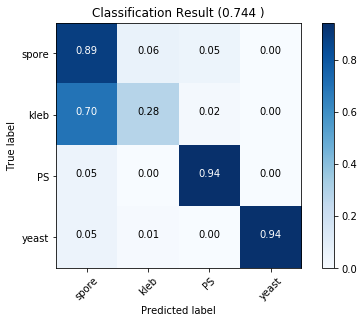

1744.4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               197632    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 206,148
Trainable params: 206,148
Non-trainable params: 0
_________________________________________________________________
None
623/623 [==============================] - 0s 19us/step
Score: 0.7592295348931277, SKScore: 0.7592295345104334
0.75922953451

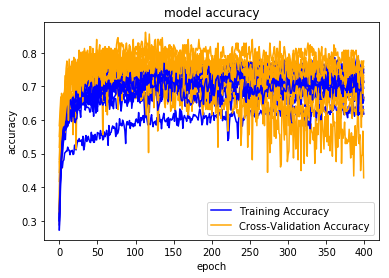

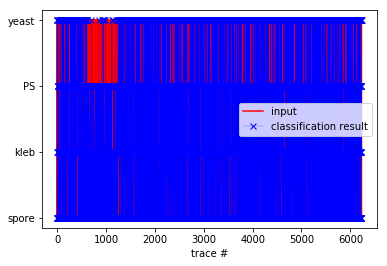

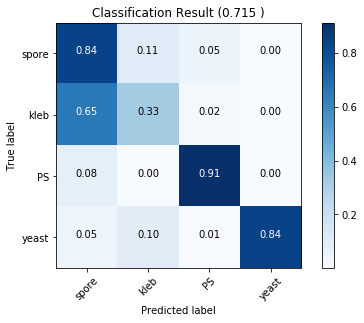

1555.6
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               173440    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 181,956
Trainable params: 181,956
Non-trainable params: 0
_________________________________________________________________
None
623/623 [==============================] - 0s 18us/step
Score: 0.8218298558247414, SKScore: 0.8218298555377207
0.82182985553

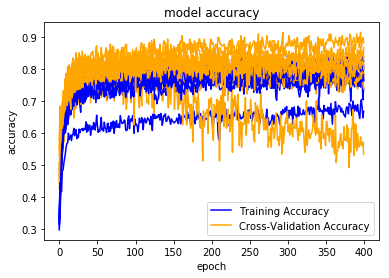

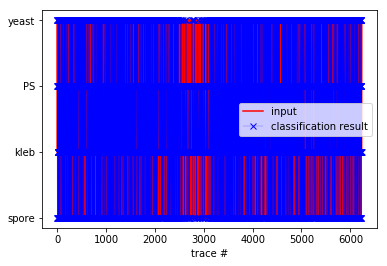

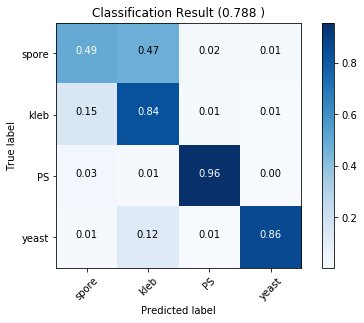

1366.7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               149248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 157,764
Trainable params: 157,764
Non-trainable params: 0
_________________________________________________________________
None
623/623 [==============================] - 0s 18us/step
Score: 0.8282504014754564, SKScore: 0.8282504012841091
0.82825040128

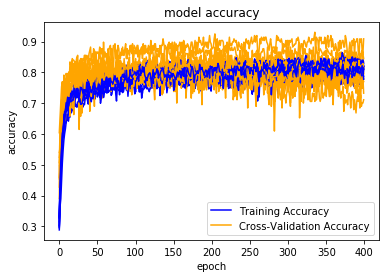

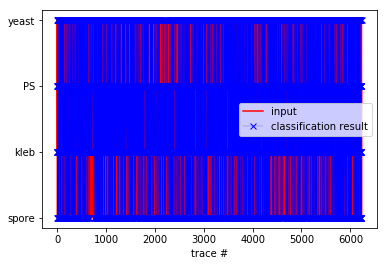

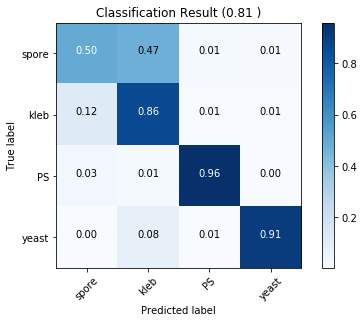

1177.8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               125056    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 133,572
Trainable params: 133,572
Non-trainable params: 0
_________________________________________________________________
None
623/623 [==============================] - 0s 17us/step
Score: 0.8057784914587703, SKScore: 0.8057784911717496
0.80577849117

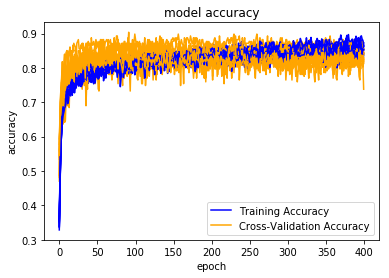

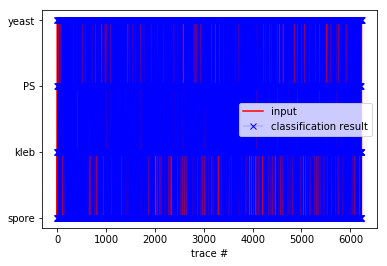

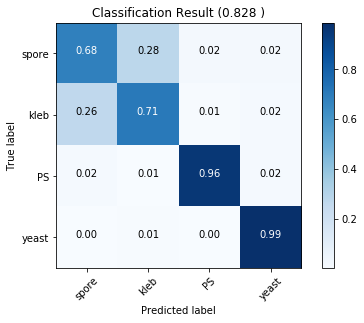

988.9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 109,380
Trainable params: 109,380
Non-trainable params: 0
_________________________________________________________________
None
623/623 [==============================] - 0s 18us/step
Score: 0.7833065811550637, SKScore: 0.78330658105939
0.78330658105939

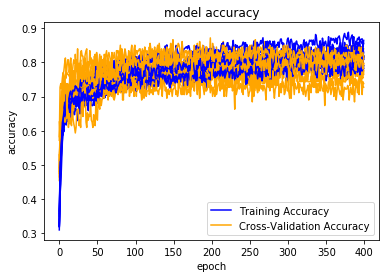

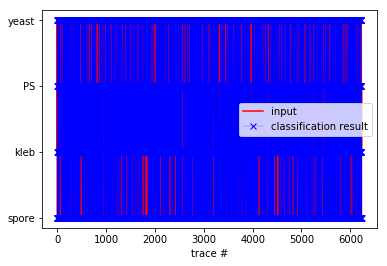

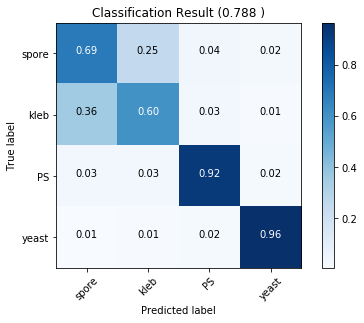

800.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               76800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 85,316
Trainable params: 85,316
Non-trainable params: 0
_________________________________________________________________
None
623/623 [==============================] - 0s 18us/step
Score: 0.8009630822446526, SKScore: 0.8009630818619583
0.80096308186195

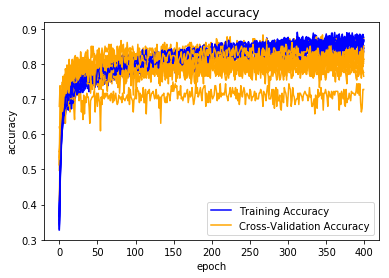

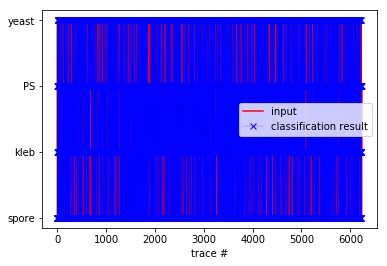

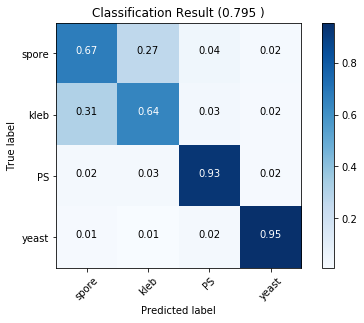

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Text xticklabel objects>)

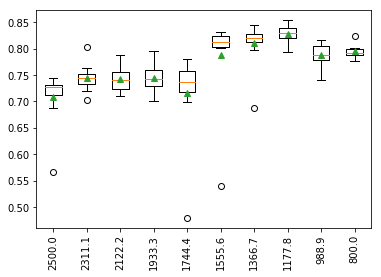

In [7]:
connected_labels,connected_scores = runModel(numRepetitions=10)
plt.boxplot(np.transpose(connected_scores), labels=connected_labels, showmeans=True)
plt.xticks(rotation=90)

In [8]:
def runModelCNN(numRepetitions=1):
    scores=[]
    labels=[]
   
    rangeEnds=np.linspace(2500,800,10)
    for rangeEnd in rangeEnds:
    
        for normalize in [False,True]:
            runScores=[]
            results=[]
            truths=[]
            label="{0:.1f}\nNormalize: {1}".format(rangeEnd,str(normalize))
            labels.append(label)
            print(label)
            
            for i in range(numRepetitions):
                
                dist=rangeEnd-startPNT
            
                xTrain,xTest,yTrain,yTest=makeRandomDataBySpectra(start=startPNT,
                                                                  end=rangeEnd,
                                                                  points=dist)
                
                reshapedTraining = np.expand_dims(xTrain, axis=2)
                reshapedValidation = np.expand_dims(xTest, axis=2)
            
                
                model=makeModelCNN(points=reshapedTraining.shape[1],batchNormalize=normalize)
                
                if i==0:
                    print(model.summary())
        
                history = model.fit(reshapedTraining, yTrain, epochs=100, validation_split=0.05, verbose=0)
                score = model.evaluate(reshapedValidation, yTest)
                prd = model.predict(reshapedValidation)
                
                skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(yTest),scalarClassesFromOneHotArray(prd))
                print("Score: {}, SKScore: {}".format(score[1], skScore))
                print(skScore)
                results.extend(scalarClassesFromOneHotArray(prd))
                runScores.append(skScore)
                truths.extend(scalarClassesFromOneHotArray(yTest))
                plt.plot(history.history['acc'], color='blue')
                plt.plot(history.history['val_acc'], color='orange')
                
                K.clear_session()
                del history
                del model
                gc.collect()
            
            avgScore=sum(runScores)/float(len(runScores))
            print("Score: {}".format(avgScore))
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
            plt.show()
            scores.append(runScores)
            pt.plotResult(results,truths,sortedTypes)
            mtrx = metrics.confusion_matrix(truths,results)
            pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % avgScore, normalize=True)
    
    npScores=np.array(scores)
    
    return labels,npScores


2500.0
Normalize: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2279, 16)          352       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2279, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1129, 32)          5664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1129, 32)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 564, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 560, 64)        

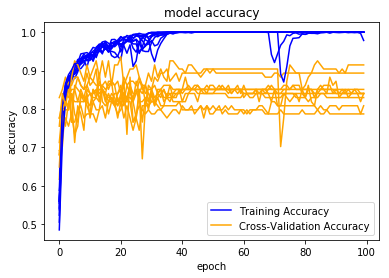

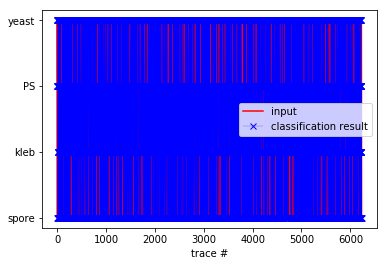

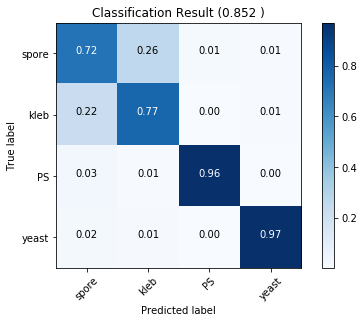

2500.0
Normalize: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2279, 16)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2279, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2279, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1129, 32)          5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1129, 32)          128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1129, 32)        

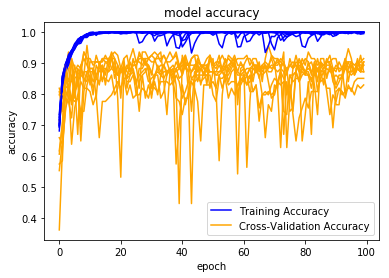

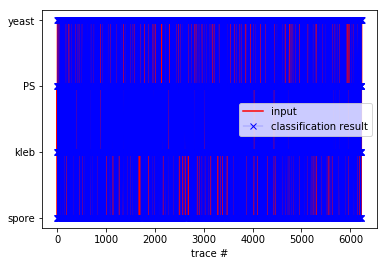

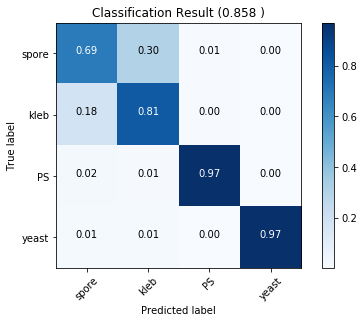

2311.1
Normalize: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2090, 16)          352       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2090, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1045, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1035, 32)          5664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1035, 32)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 517, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 513, 64)        

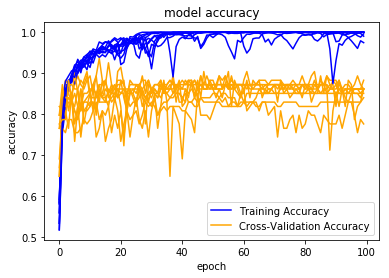

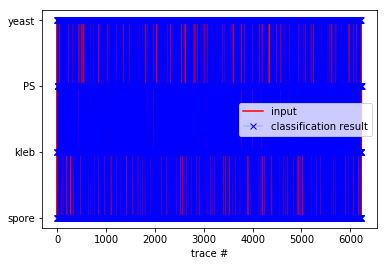

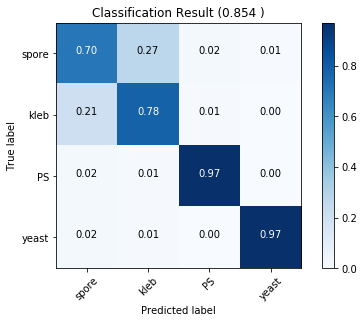

2311.1
Normalize: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2090, 16)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2090, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2090, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1045, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1035, 32)          5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1035, 32)          128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1035, 32)        

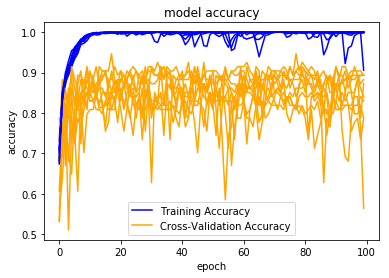

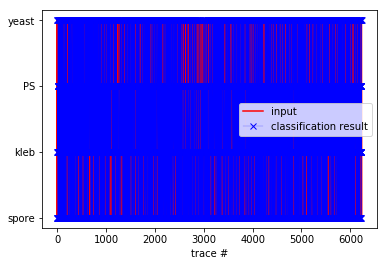

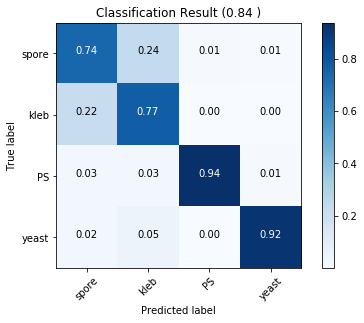

2122.2
Normalize: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1901, 16)          352       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1901, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 950, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 940, 32)           5664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 940, 32)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 470, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 466, 64)        

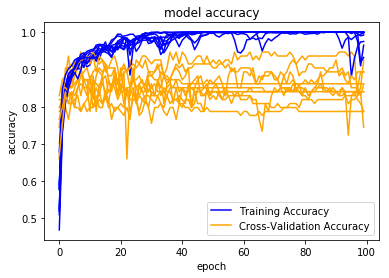

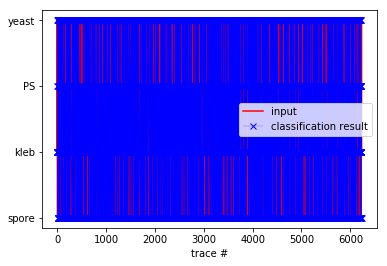

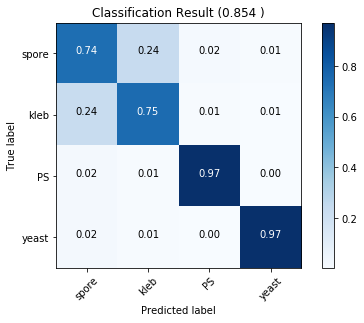

2122.2
Normalize: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1901, 16)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1901, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1901, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 950, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 940, 32)           5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 940, 32)           128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 940, 32)         

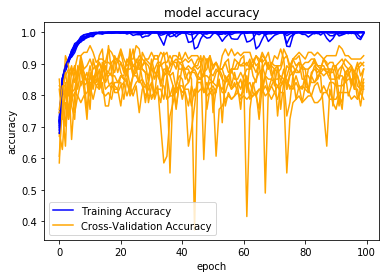

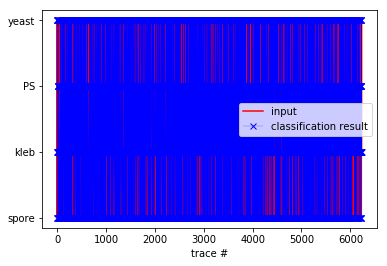

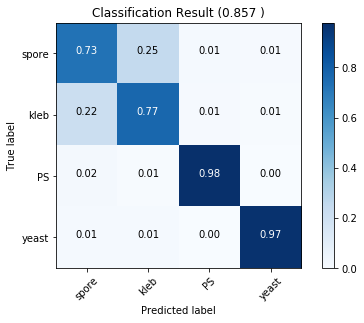

1933.3
Normalize: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1712, 16)          352       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1712, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 856, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 846, 32)           5664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 846, 32)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 423, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 419, 64)        

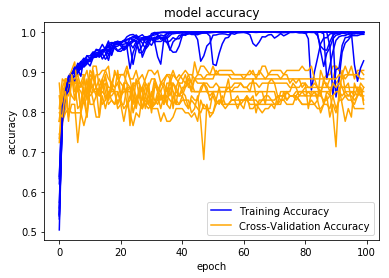

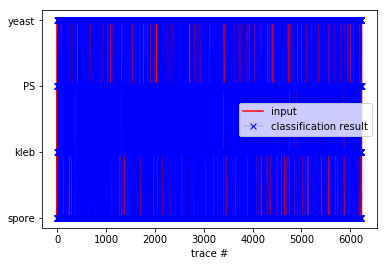

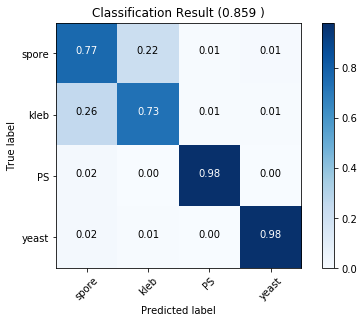

1933.3
Normalize: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1712, 16)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1712, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1712, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 856, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 846, 32)           5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 846, 32)           128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 846, 32)         

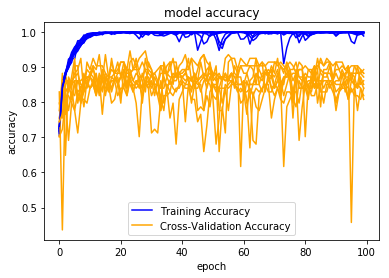

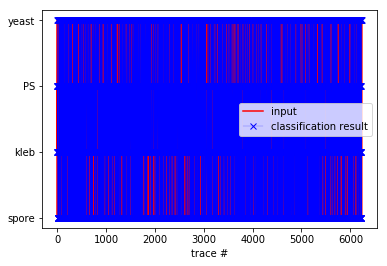

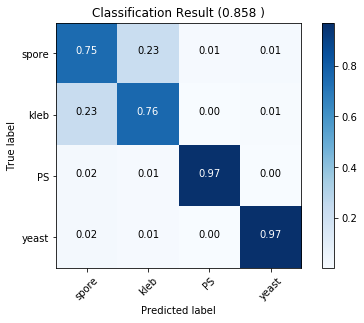

1744.4
Normalize: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1523, 16)          352       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1523, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 761, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 751, 32)           5664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 751, 32)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 375, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 371, 64)        

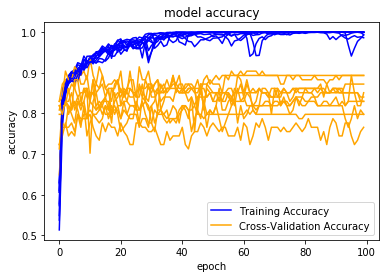

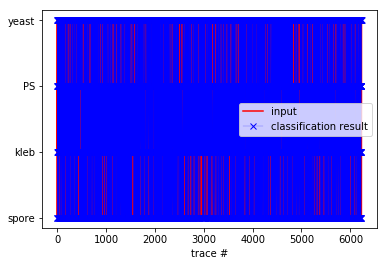

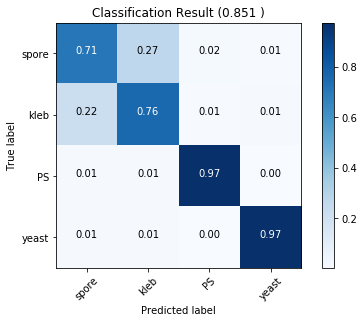

1744.4
Normalize: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1523, 16)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1523, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1523, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 761, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 751, 32)           5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 751, 32)           128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 751, 32)         

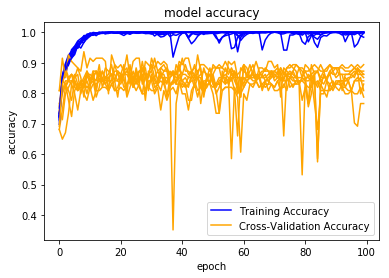

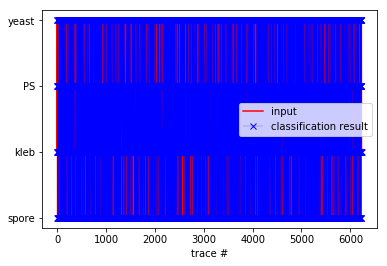

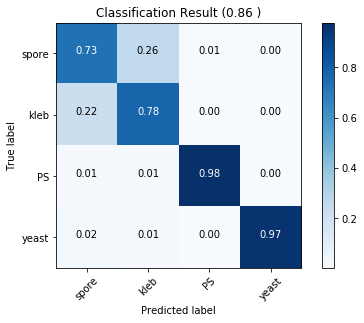

1555.6
Normalize: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1334, 16)          352       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1334, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 667, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 657, 32)           5664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 657, 32)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 328, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 324, 64)        

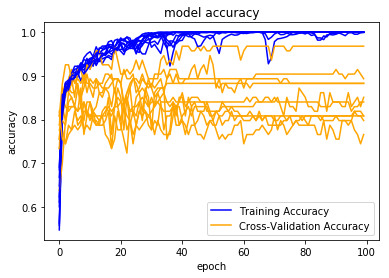

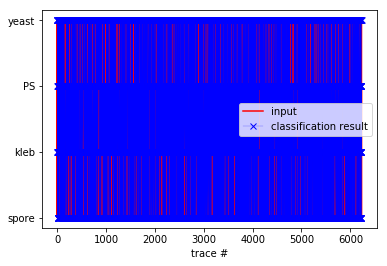

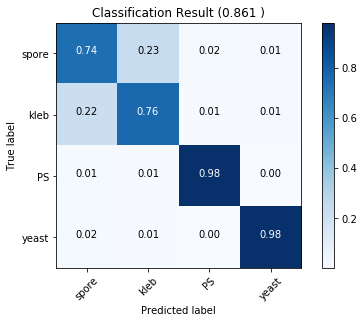

1555.6
Normalize: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1334, 16)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1334, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1334, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 667, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 657, 32)           5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 657, 32)           128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 657, 32)         

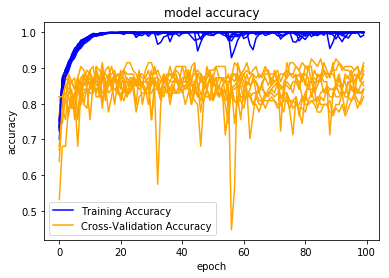

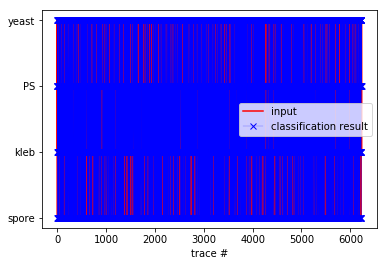

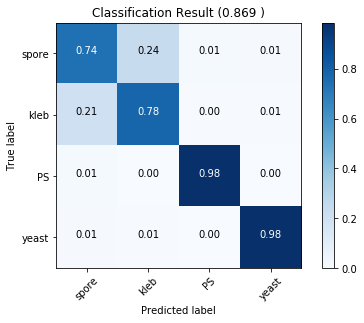

1366.7
Normalize: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1145, 16)          352       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1145, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 572, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 562, 32)           5664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 562, 32)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 281, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 277, 64)        

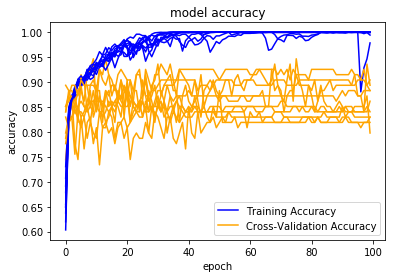

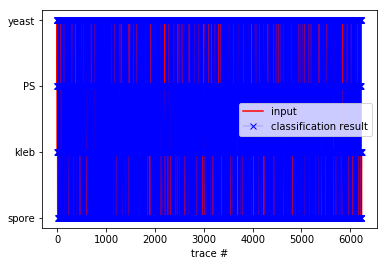

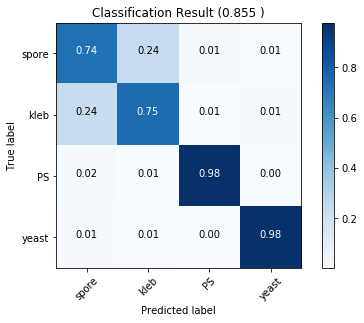

1366.7
Normalize: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1145, 16)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1145, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1145, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 572, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 562, 32)           5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 562, 32)           128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 562, 32)         

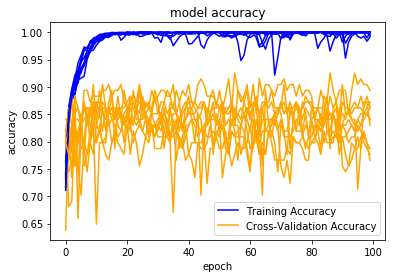

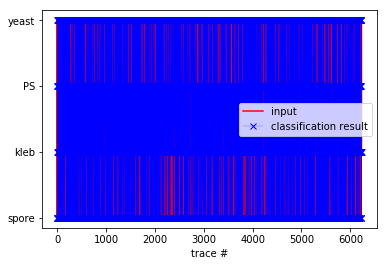

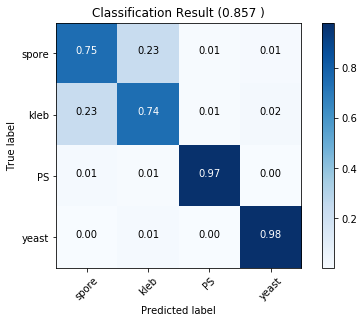

1177.8
Normalize: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 956, 16)           352       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 956, 16)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 478, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 468, 32)           5664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 468, 32)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 234, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 230, 64)        

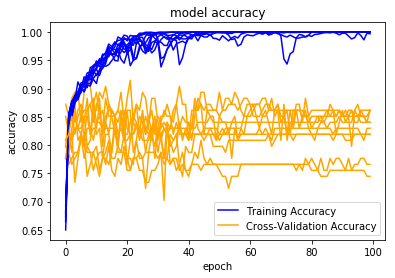

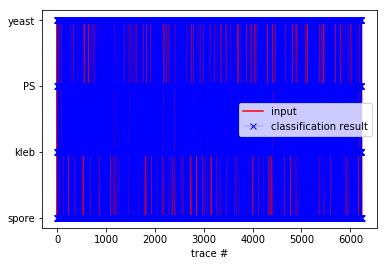

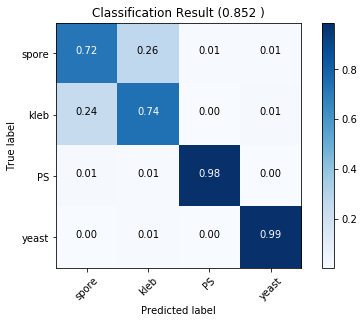

1177.8
Normalize: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 956, 16)           352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 956, 16)           64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 956, 16)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 478, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 468, 32)           5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 468, 32)           128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 468, 32)         

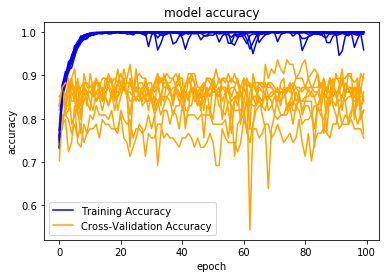

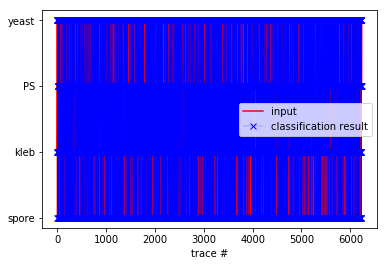

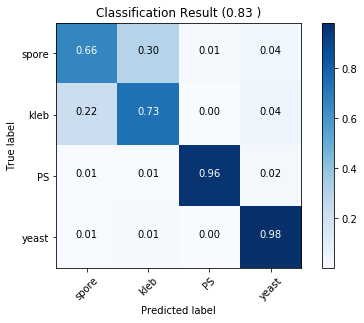

988.9
Normalize: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 767, 16)           352       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 767, 16)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 383, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 373, 32)           5664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 373, 32)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 186, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 182, 64)         

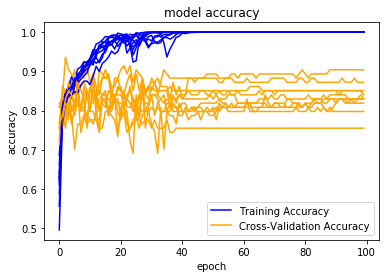

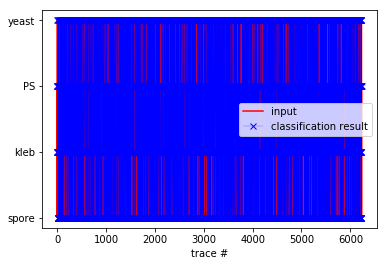

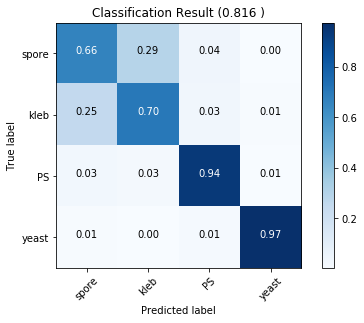

988.9
Normalize: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 767, 16)           352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 767, 16)           64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 767, 16)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 383, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 373, 32)           5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 373, 32)           128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 373, 32)          

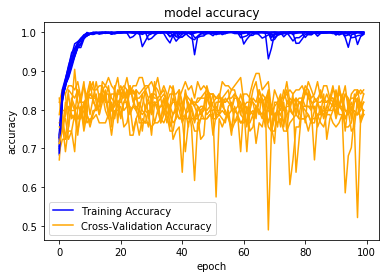

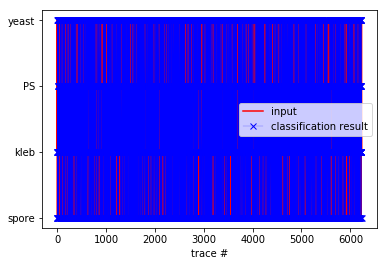

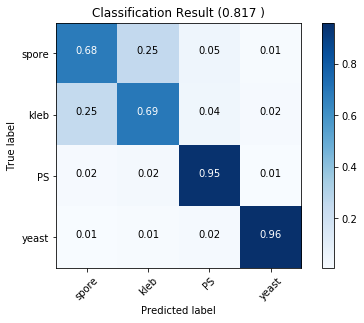

800.0
Normalize: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 579, 16)           352       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 579, 16)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 289, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 279, 32)           5664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 279, 32)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 139, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 135, 64)         

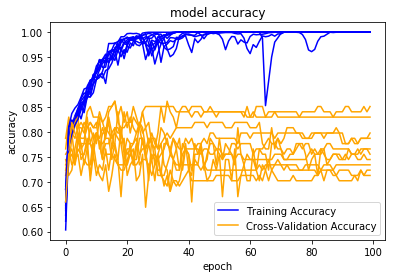

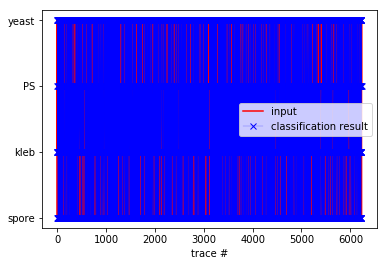

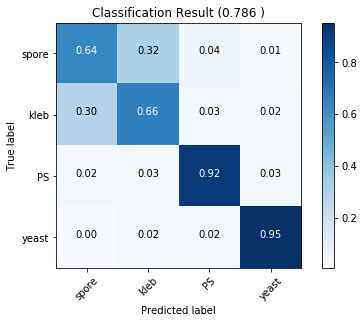

800.0
Normalize: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 579, 16)           352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 579, 16)           64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 579, 16)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 289, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 279, 32)           5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 279, 32)           128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 279, 32)          

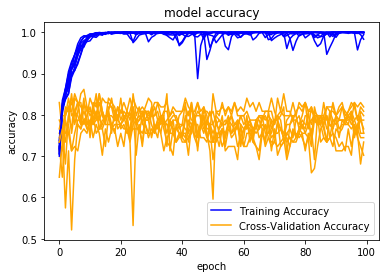

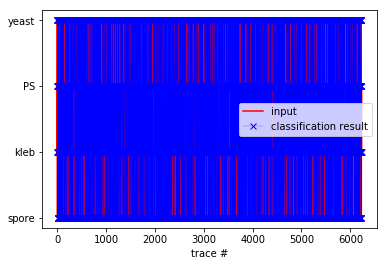

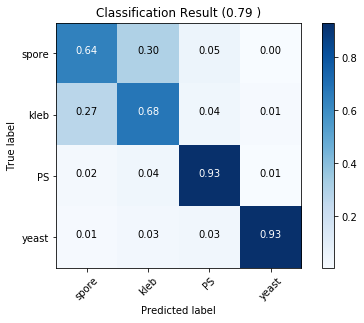

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]), <a list of 20 Text xticklabel objects>)

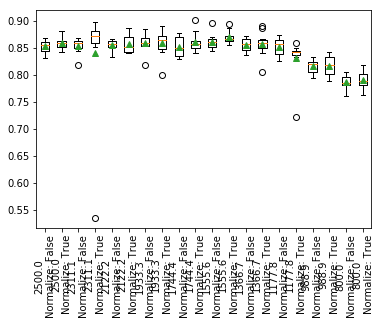

In [9]:
cnn_labels,cnn_scores = runModelCNN(10)
plt.boxplot(np.transpose(cnn_scores), labels=cnn_labels, showmeans=True)
plt.xticks(rotation=90)